
## About this project

I want to make an analysis about the status of APARTMENTS in real state market.

Metricas a calcular:

Estadisticos:
    Cantidad total
    Precio promedio
    Precio mediano
    Dispersion(p99, p1, desviacion tipica)
Abiertas por:
    * Gran Mendoza(General)
    * Departamentos(chacras separado)
    * Inmobiliaria
    * Tipo de precio (Dolar, Peso, no se sabe)
    * Tipo de inmueble (Lote, Departamento, Casa)
    * *Rango de interes*

Rangos de interes segun inmueble:
    Lotes - Tamaño m2::
        - 0..300
        - 300..500
        - 500..1000
        - 1000..
    Departamentos - Tamaño m2:
        - 40..60
        - 60..90
        - 90..
    Casas - Superficie cubierta m2:
        - 90..120
        - 120..240
        - 240..

In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
from selenium import webdriver
import pandas as pd
import time
import random
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../'))
from utils import (soup_content_from_url,
                    elements_from_soup_bestsellers_web, 
                    subcategories_from_bestsellers_web,
                    detail_dict_from_product_page,
                    load_obj,
                    save_obj)

# EDA

Estadisticos:
* Describe district
* 

In [130]:
import seaborn as sns
from matplotlib import pyplot as plt
filename = "dataframe_apartment.csv"
df = pd.read_csv(filename)
df.head(3)

,ref_id,neighborhood,district,province,price,currency,amount,url,description,totalArea,bedrooms,bathrooms,floorArea,agency,property_type,source_web,scrapped_date
0,inmueble-438-2913,F Moyano 1525 Quinta Sección Edificio H,Capital,Mendoza,US$ 180.000,US$,180000.0,/438-de-lucia/inmuebles/2913/ficha/departament...,Inmobiliaria De Lucia vende Departamento en co...,140,2,2.0,83,De Lucia,PropertyType.APARTMENT,inmoclick,2020-07-18
1,inmueble-11737-62,PASO,Maipu,Mendoza,US$ 47.000,US$,47000.0,/11737-las-marias-desarrollos-inmobiliarios/in...,"SOS INVERSOR Y BUSCÁS UN DESARROLLO EN MAIPÚ, ...",85,2,1.0,75,Inmobiliaria,PropertyType.APARTMENT,inmoclick,2020-07-18
2,inmueble-5949-987,Victor Fayad,Maipu,Mendoza,US$ 78.000,US$,78000.0,/5949-alessandra-mariani/inmuebles/987/ficha/d...,ALESSANDRA MARIANI VENDE\nHermoso Complejo Cer...,100,2,2.0,80,Alessandra Mariani,PropertyType.APARTMENT,inmoclick,2020-07-18


In [131]:
df.scrapped_date.max()

'2020-07-18'

In [132]:
len(df.ref_id.unique())

2304

In [133]:
df.currency = df.currency.fillna('consultar')

In [134]:
df.district.unique()
print(f"Cantidad total de propiedades originales:{len(df)}")
gran_mendoza_list = ['Godoy Cruz', 'Maipu', 'Lujan de Cuyo', 'Las Heras', 'Capital',
       'Carrodilla', 'Guaymallen', 'Chacras de Coria',
       'Vistalba', 'Mayor Drummond', 'Perdriel', 'La Puntilla']
df = df[df.district.isin(gran_mendoza_list)]
print(f"Cantidad total de propiedades en el Gran Mendoza:{len(df)}")

Cantidad total de propiedades originales:2304
Cantidad total de propiedades en el Gran Mendoza:2290


## Tipo de inmuebles : Lotes y Terrenos

### Composicion por tipo de moneda

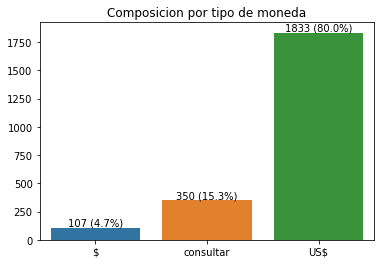

In [135]:
curr = df.groupby('currency').count().ref_id.sort_values()
share = round(curr/curr.sum()*100,1)
g = sns.barplot(x=curr.index.values,y=curr.values)
for i,row in enumerate(curr.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i,row[1], bar_text, color='black', ha="center",va='bottom')
    
g.set_title('Composicion por tipo de moneda')
plt.show()

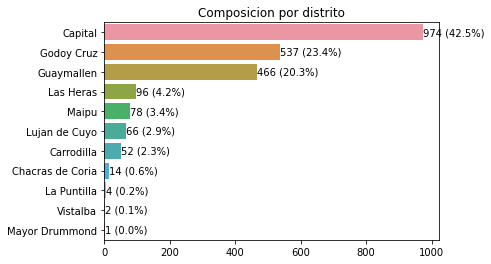

In [136]:
districts = df.groupby('district').count().ref_id.sort_values(ascending=False)
share = round(districts/districts.sum()*100,1)
g = sns.barplot(x=districts.values,y=districts.index.values)

for i,row in enumerate(districts.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por distrito')
plt.show()

### Composicion por inmobiliaria

total agencies:215


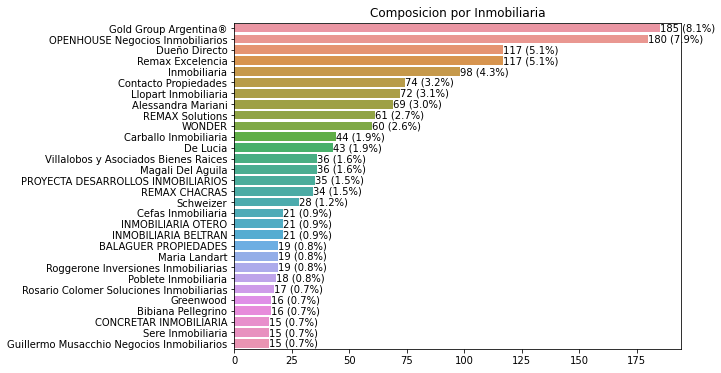

In [137]:
agency = df.groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("total agencies:"+str(len(agency)))

agency = agency.head(30)
plt.figure(figsize=(8,6))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por Inmobiliaria')
plt.show()

### Creating totalArea ranges

In [114]:
# Percent of disables
100.0 * len(df[df['totalArea']=='disable'])/len(df)

9.301310043668122

In [115]:
# Fixing types
# Removing disables
df = df[df['totalArea']!='disable']
# Removing string chars in totalArea
df['totalArea_fixed'] = df.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df.totalArea_fixed = df.totalArea_fixed.str.strip()
def cast_to_comma(value):
    if len(value)>= 3 and value[-3]==".":
        return value.replace(".",',')
    else:
        return value
df.totalArea_fixed = df.totalArea_fixed.apply(lambda x: cast_to_comma(x))
print(df[['totalArea_fixed','totalArea']])
df.totalArea_fixed = df.totalArea_fixed.str.replace('.', '')
df.totalArea_fixed = df.totalArea_fixed.str.replace(',', '.')
df.totalArea_fixed = pd.to_numeric(df.totalArea_fixed, errors='coerce')

     totalArea_fixed totalArea
0                140       140
1                 85        85
2                100       100
3                100       100
4                 97        97
...              ...       ...
2280             150       150
2281              90        90
2292              71        71
2302              40        40
2303              54        54

[2077 rows x 2 columns]


In [116]:
# Percent of floorArea in disable
100.0 * len(df[df['floorArea']=='disable'])/len(df)

0.04814636494944632

In [117]:
len(df[df['url'].str.contains("depart")])/len(df)


0.8858931150698123

In [118]:
# Removing disables
df = df[df['floorArea']!='disable']
df['floorArea_fixed'] = df.floorArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df.floorArea_fixed = df.floorArea_fixed.str.strip()
def cast_to_comma(value):
    if isinstance(value,str) and len(value)>= 3 and value[-3]==".":
        return value.replace(".",',')
    else:
        return value
df.floorArea_fixed = df.floorArea_fixed.apply(lambda x: cast_to_comma(x))
print(df[['floorArea_fixed','floorArea']])
df.floorArea_fixed = df.floorArea_fixed.str.replace('.', '')
df.floorArea_fixed = df.floorArea_fixed.str.replace(',', '.')
df.floorArea_fixed = pd.to_numeric(df.floorArea_fixed, errors='coerce')
# Avoid apartments with less of 10 square meters
df = df[df.floorArea_fixed >= 10]

     floorArea_fixed floorArea
0                 83        83
1                 75        75
2                 80        80
3                 75        75
4                 97        97
...              ...       ...
2280              98        98
2281              80        80
2292              71        71
2302              42        42
2303              60        60

[2076 rows x 2 columns]


In [119]:
def bucketizer(df, bucket_limits, field, new_field):
    prev_limit = None
    ranges = []
    for i,limit in enumerate(bucket_limits):
        if i==0:
            df.loc[df[field] <= limit, new_field] = 0
            ranges = ["0.."+str(limit)]
        elif i==len(bucket_limits)-1:
            df.loc[np.logical_and(df[field] > prev_limit,df[field] <= limit), new_field] = prev_limit
            ranges.append(str(prev_limit)+".."+str(limit))
            
            df.loc[df[field] > limit, new_field] = limit
            ranges.append(str(limit)+"..")
        else:
            df.loc[np.logical_and(df[field] > prev_limit,df[field] <= limit), new_field] = prev_limit
            ranges.append(str(prev_limit)+".."+str(limit))
        prev_limit = limit
    return ranges

In [120]:
"""
Lotes - Tamaño m2::
        - 0..300
        - 300..500
        - 500..1000
        - 1000..
"""
bucket_separators = [40,60,90]
#field = "totalArea_fixed"
field = "floorArea_fixed"
new_field="depto_range"
ranges = bucketizer(df, bucket_separators, field, new_field)
ranges

['0..40', '40..60', '60..90', '90..']

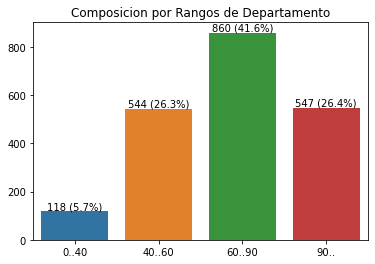

In [121]:
depto_range = df.groupby('depto_range').count().ref_id#.sort_values(ascending=False)
share = round(depto_range/depto_range.sum()*100,1)
g = sns.barplot(x=ranges, y=depto_range.values)

for i,row in enumerate(depto_range.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i, row[1], bar_text, color='black', ha="center",va='bottom',rotation=0)
g.set_title('Composicion por Rangos de Departamento')
plt.show()

In [122]:
df["squared_meter_amount"] = df.amount/df.floorArea_fixed

In [123]:
#district_landr = (df[df['currency']=='US$'].groupby(["district","land_range"])
#.agg({'squared_meter_amount':['mean'],'ref_id':['count']}))
pd.pivot_table(df[df['currency']=='US$'],
               values=['squared_meter_amount','ref_id'],
               index='district',
               columns='depto_range',
               aggfunc={'squared_meter_amount':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

### Removing outliers

In [124]:
from scipy import stats
dolarized = df[df['currency']=='US$']
print(f"dolarized with outliers {len(dolarized)}")
z_scores = stats.zscore(dolarized.amount)
abs_z_scores = np.abs(z_scores)
dolarized = dolarized[(abs_z_scores < 3)]

z_scores = stats.zscore(dolarized.floorArea_fixed)
abs_z_scores = np.abs(z_scores)
dolarized = dolarized[(abs_z_scores < 3)]
print(f"dolarized without outliers {len(dolarized)}")

dolarized with outliers 1728
dolarized without outliers 1698


In [125]:
pd.pivot_table(dolarized,
               values=['squared_meter_amount','ref_id'],
               index='district',
               columns='depto_range',
               aggfunc={'squared_meter_amount':'mean',
                        'ref_id':'count'}).style.format("{:.1f}")

In [126]:
df[np.logical_and(df.district=='Chacras de Coria',df.depto_range==0.0)].url.values

array(['/11248-openhouse-negocios-inmobiliarios/inmuebles/2136/ficha/departamento-en-venta-en-panamericana-chacras-de-coria-complejo-del-oeste?btid=3419443'],
      dtype=object)

In [27]:
lujan = df[df['currency']=='US$']
lujan = lujan[lujan.land_range==1000]
lujan = lujan[lujan['district']== 'Chacras de Coria']
lujan[['price','amount','totalArea','totalArea_fixed']].head(30)
#df[df.index==791].url.values

AttributeError: 'DataFrame' object has no attribute 'land_range'

### Abierto por departamentos

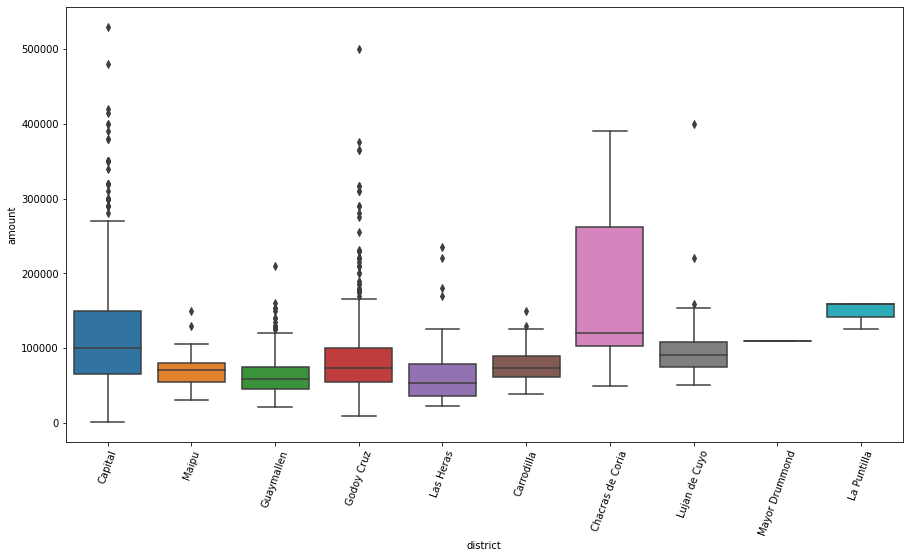

In [40]:
plt.figure(figsize=(15,8))
g = sns.boxplot(x=dolarized[dolarized.currency=='US$']['district'], y=df['amount'])
g.set_xticklabels(g.get_xticklabels(),rotation=70)
plt.show()

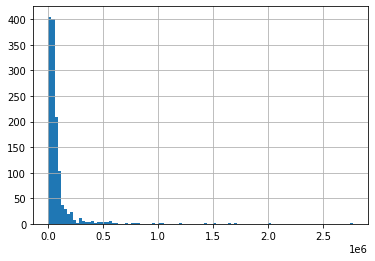

In [77]:
df[df.currency=='US$'].amount.hist(bins=100)

In [78]:
import numpy as np
#df[np.logical_and(df['amount']<30000,df['amount']>0)].sort_values(by='amount')
df[df.description.str.contains("2018")].description

13      Gold Group Argentina® Vende!!\nMagníficos lote...
16      Gold Group Argentina® Vende!\nExcelentes lotes...
59      GOLD GROUP !!! VENDE !!! \nHermoso lote comple...
60      GOLD GROUP ARGENTINA® VENDE!!\nFantásticos y e...
61      GOLD GROUP ARGENTINA® VENDE!!\n\nLotes desde 4...
                              ...                        
1847    GOLD GROUP VENDE! LOTE EN "LOTEO AMPA" \nEL MI...
1898    EXCELENTE TERRENO EN GODOY CRUZ IDEAL PARA DES...
1899    GOLD GROUP ARGENTINA® VENDE!\nCalle Colombia y...
1948    LOTE EN BARRIO PRIVADO PALMARES VALLEY\nLAS JA...
2030    GOLD GROUP vende 8 selectos lotes en este excl...
Name: description, Length: 81, dtype: object

In [79]:
str(df[df.index==3175].url.values)

'[]'

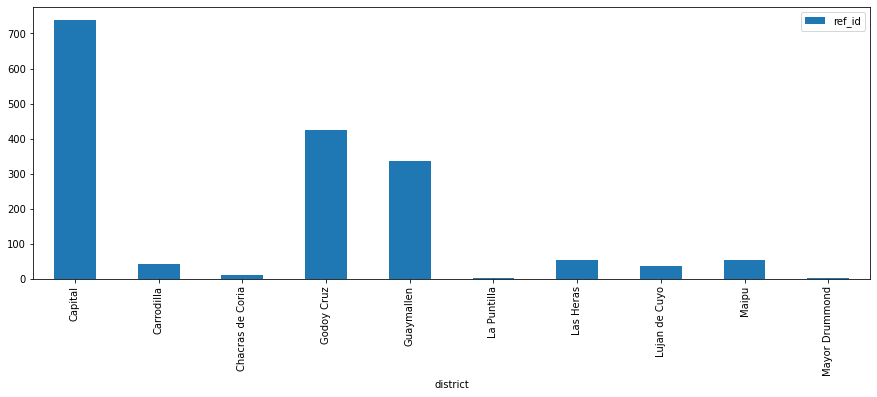

In [41]:
dolarized.groupby('district').count().plot.bar(y='ref_id',figsize=(15,5))

In [33]:
dfdol = df[df.currency=='US$'].reset_index(drop=True)
dfdol['r_10'] = round(dfdol.recent_id/100)
h = dfdol.groupby('r_10').mean()
#pd.pivot_table(h,values,index='r_10',columns,aggfunc)

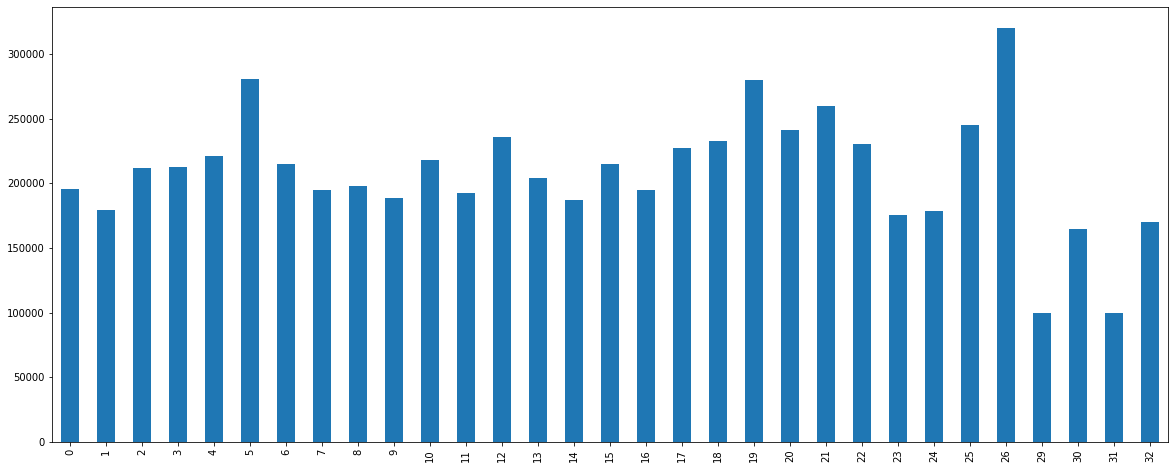

In [34]:
plt.figure(figsize=(20,8))
h.index = h.index.astype(int)
h['amount'].plot.bar()

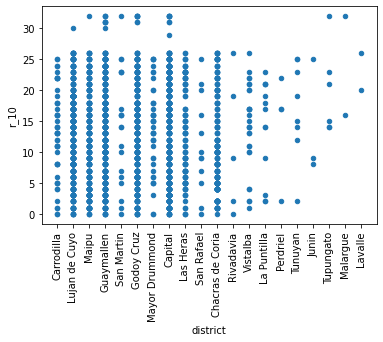

In [42]:
dfdol.plot.scatter(x='district',y='r_10',rot=90)

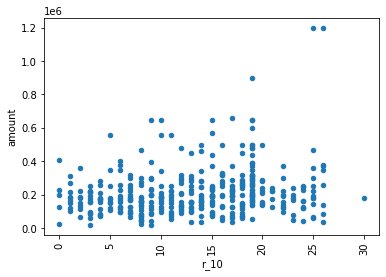

In [46]:
dfdol[dfdol.district=='Lujan de Cuyo'].plot.scatter(x='r_10',y='amount',rot=90)

In [68]:
import numpy as np
pd.set_option('display.max_columns', 30)
list(dfdol[dfdol['r_20']==3].url)

['https://www.inmoclick.com.ar/71779-greenwood/inmuebles/82/ficha/casa-en-venta-en-acceso-este-y-arturo-gonzalez?btid=2465480',
 'https://www.inmoclick.com.ar/71779-greenwood/inmuebles/84/ficha/casa-en-venta-en-juan-agustin-maza-y-azcuenaga?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1479/ficha/casa-en-venta-en-b0-privado-bucci-bandera-de-los-andes-y-rosario?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1500/ficha/casa-en-venta-en-laguna-horcones-1054-barrio-fuchs?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1508/ficha/casa-en-venta-en-vicente-gil-539?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1515/ficha/casa-en-venta-en-rufino-ortega-y-martinez-de-rozas?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1518/ficha/casa-en-venta-en-p-benegas-691?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-g

In [175]:
df2 = df[df['totalArea']!='disable']
df2.totalArea = df2.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df2.totalArea = df2.totalArea.str.strip()
df2 = df2[~df2['totalArea'].str.contains('2.852.61')]
df2.totalArea = df2['totalArea'].str.replace(',','.')

In [176]:
df2.totalArea = df2.totalArea.astype(float)

In [177]:
df2.floorArea[df2.floorArea.str.contains('\,')]

295     301,24m2
1142     57,78m2
1144     80,00m2
1204    411,00m2
1427    69,10 m2
1475    65,83 m2
1484       334,3
1675       97,15
1759    453,85m2
1760    258,32m2
1800      135,53
2006      170,47
2083    221,50m2
3038       483,6
3074      299,35
3089    313,58m2
Name: floorArea, dtype: object

In [178]:
df2 = df2[df2['floorArea']!='disable']
df2 = df2[df2['floorArea']!='140/60']
df2.floorArea = (df2.floorArea.str.replace('mts2','')
                             .str.replace('m2','')
                             .str.replace('m','')
                             .str.replace('aprox.con cocher','')
                             .str.replace('aprox.','')
                             .str.replace(',',''))
df2.floorArea = df2.floorArea.astype(float)

In [179]:
df2.loc[df2['totalArea'] >= 4000,'totalArea']=4000

In [205]:
chacras = df2[np.logical_and(df2['district']=='Chacras de Coria',df2.currency=='US$')]

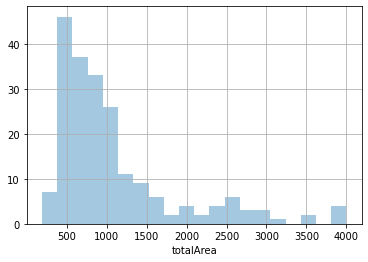

In [232]:
import seaborn as sns
g = sns.distplot(chacras.totalArea,bins=20,kde=False)
g.grid()

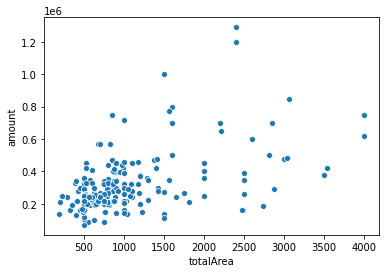

In [208]:
sns.scatterplot(x="totalArea", y="amount", data=chacras)

In [230]:
chacras['amountr'] = pd.qcut(chacras.amount,5)

/home/chanchus/developments/amz-scrapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


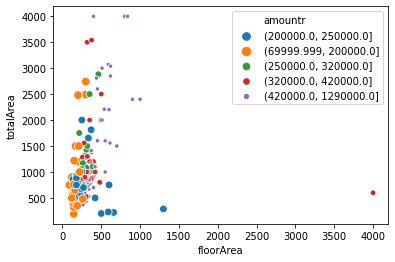

In [231]:
sns.scatterplot(x="floorArea", y="totalArea",hue="amountr", size="amountr", data=chacras)

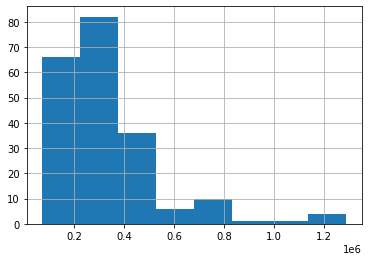

In [217]:
chacras.amount.hist(bins=8)

In [2]:
import pandas as pd

In [5]:
df1 = pd.DataFrame([['Buenos Aires',63,16,89,55],
				['Atlanta',17,29,81,17],
				['Brasil',88,82,9, 64]])
df1.columns=['Airport','A','B','C','D']
df1 = df1.set_index('Airport')

df2 = pd.DataFrame([['Buenos Aires',21,38,36],
		['Atlanta',54,88,80],
		['Brasil',44,53,53],
		['Madrid',24,58,29]])
df2.columns=['Airport','B','C','D']
df2 = df2.set_index('Airport')


,B,C,D
Airport,,,
Buenos Aires,21,38,36
Atlanta,54,88,80
Brasil,44,53,53
Madrid,24,58,29


In [6]:
df1.merge(df2, left_index=True,right_index=True)

,A,B_x,C_x,D_x,B_y,C_y,D_y
Airport,,,,,,,
Buenos Aires,63,16,89,55,21,38,36
Atlanta,17,29,81,17,54,88,80
Brasil,88,82,9,64,44,53,53
